# Assignment 5: Link Analysis

In this assignment, we will use network-based algorithms, such as PageRank, to improve our search results. After the last assignment on evaluating IR systems, we go back to our PubMed dataset of scientific papers. In this dataset, we look at two graphs in particular: the co-authorship network and the citation network.

The citation network is similar to the link network of the web: Citations are like web links pointing to other documents. We can therefore apply the same network-based ranking methods.

## Code from previous assignments

In [1]:
import pickle, bz2
from collections import defaultdict, namedtuple, Counter
from math import log10, sqrt
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100

In [2]:
Ids_file = 'data/fungus_Ids.pkl.bz2'
Summaries_file = 'data/fungus_Summaries.pkl.bz2'
Citations_file = 'data/fungus_Citations.pkl.bz2'
Abstracts_file = 'data/fungus_Abstracts.pkl.bz2'

Ids = pickle.load( bz2.BZ2File( Ids_file, 'rb' ) )
Summaries = pickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )
Citations = pickle.load( bz2.BZ2File( Citations_file, 'rb' ) )
Abstracts = pickle.load( bz2.BZ2File( Abstracts_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.items():
    Summaries[id] = paper( *paper_info )

In [3]:
def display_summary( id, show_abstract=False, show_id=True, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long author lists, and adds a link to the paper's DOI (when available).
    """
    s = Summaries[id]
    lines = []
    title = s.title
    if s.doi != '':
        title = '<a href=http://dx.doi.org/{:s}>{:s}</a>'.format(s.doi, title)
    title = '<strong>' + title + '</strong>'
    lines.append(title)
    authors = ', '.join( s.authors[:20] ) + ('' if len(s.authors) <= 20 else ', ...')
    lines.append(str(s.year) + '. ' + authors)
    if (show_abstract):
        lines.append('<small><strong>Abstract:</strong> <em>{:s}</em></small>'.format(Abstracts[id]))
    if (show_id):
        lines.append('[ID: {:d}]'.format(id))
    if (extra_text != ''):
         lines.append(extra_text)
    display( HTML('<br>'.join(lines)) )

In [4]:
def tokenize(text):
    return text.split(' ')

def preprocess(tokens):
    result = []
    for token in tokens:
        result.append(token.lower())
    return result

In [5]:
inverted_index = defaultdict(list)

for id in sorted(Summaries.keys()):
    term_set = set(preprocess(tokenize(Summaries[id].title)))
    if id in Abstracts:
        term_set.update(preprocess(tokenize(Abstracts[id])))
    for term in term_set:
        inverted_index[term].append(id)

tf_matrix = defaultdict(Counter)

for doc_id in Summaries.keys():
    tokens = preprocess(tokenize(Summaries[doc_id].title))
    if (doc_id in Abstracts):
        tokens.extend(preprocess(tokenize(Abstracts[doc_id])))
    tf_matrix[doc_id] = Counter(tokens)

def tf(t,d):
    return float(tf_matrix[d][t])

def df(t):
    return float(len(inverted_index[t]))

num_documents = float(len(Summaries))

def idf(t):
    return log10((num_documents + 1)/(df(t) + 1))

def tfidf(t,d):
    return tf(t,d) * idf(t)

## Co-authorship network

We start by building a mapping from authors to the set of identifiers of papers they authored.  We'll be using Python sets again for that purpose.

In [6]:
papers_of_author = defaultdict(set)

for (id, p) in Summaries.items():
    for a in p.authors:
        papers_of_author[a].add(id)

Let's try it out:

In [7]:
papers_of_author['Canessa S']

{25154107, 28425998, 29491409, 30868671}

In [8]:
for id in papers_of_author['Canessa S']:
    display_summary(id)

We can now build a co-authorship network, that is a graph linking authors to the set of co-authors they have published with:

In [9]:
coauthors = defaultdict(set)

for p in Summaries.values():
    for a in p.authors:
        coauthors[a].update(p.authors)

# The code above results in each author being listed as having co-authored with himself/herself.
# We remove these self-references here:
for (a, ca) in coauthors.items():
    ca.remove(a)

And let's try it out again:

In [10]:
print(', '.join( coauthors['Canessa S'] ))

Bogaerts S, Van Praet S, Haesebrouck F, Schmidt BR, Bosman W, Pasmans F, Schaub M, Martel A, Steinfartz S, Bert W, Rouffaer LO, Spitzen-van der Sluijs A, Laudelout A, Stegen G, Bozzuto C, Janssen N, Kinet T, Bossuyt F, Adriaensen C


Unlike a citation or link network, the edges of this co-authorship network are not directed: There is no direction (no arrow) in the link between author 'Canessa S' and 'Schmidt BR', for example. With our chosen implementation, each of these links in fact appears twice in our data, as we also get 'Canessa S' as co-author when we look for 'Schmidt BR':

In [11]:
print(', '.join( coauthors['Schmidt BR'] ))

Wagner N, Nishikawa K, Kolby JE, Verster R, Farrer RA, Clare F, Van Praet S, Nguyen TT, Grassly NC, Garcia G, Bataille A, Marin da Fonte LF, Lips KR, Sheafor B, Tessa G, Schaub M, Doherty-Bone TM, Bales EK, Oliver JA, Cunningham AA, Zamudio KR, Rouffaer LO, Veith M, Muletz C, Wierzbicki C, Ducatelle R, Soto-Azat C, Cashins S, Sabino-Pinto J, Tobler U, Wombwell E, Speybroeck J, Bletz MC, Ghosh P, Vörös J, Webb RJ, Kerres A, Blooi M, Garner TWJ, Puschendorf R, Balloux F, Ohlhoff D, Briggs CJ, Spikmans F, Doddington BJ, Bates KA, Davis LR, Dalbeck L, Martel A, Wales N, Steinfartz S, Bert W, Woodhams DC, Rieux A, Salvidio S, Jenkinson TS, Laudelout A, Stegen G, Waldman B, Kosch TA, Canessa S, Brankovics B, Bossuyt F, Meurling S, Nöllert A, Courtois EA, Martin MD, Vences M, Pasmans F, Goka K, James TY, Voyles J, Van Bocxlaer I, Muths E, Miaud C, Lin CF, Van Rooij P, Smith F, Shelton JMG, Kirst K, Lötters S, Loyau A, Skerratt LF, Bozzuto C, Gower DJ, Minting P, Laurila A, Bosch J, Böll S, Be

With that in mind, we can calculate some basic statistics about our graph:

In [12]:
print('Number of nodes (authors): ', len(coauthors))

# We divide by two here to account for the fact that each edge is represented twice (see above):
coauthor_rel_count = int(sum( len(c) for c in coauthors.values() ) / 2)
print('Number of links (co-authorship relations): ', coauthor_rel_count)

Number of nodes (authors):  120759
Number of links (co-authorship relations):  708774


With this data at hand, we can plot the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) by showing the number of collaborators a scientist has published with:

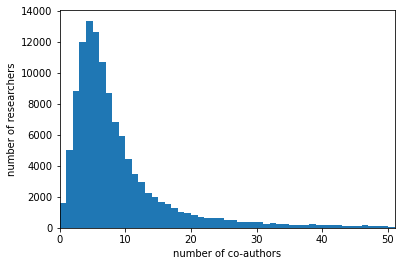

In [13]:
plt.hist( x=[ len(ca) for ca in coauthors.values() ], bins=range(60) )
plt.xlabel('number of co-authors')
plt.ylabel('number of researchers')
plt.xlim(0,51);

Now that we have explored this network, let's move to the citation network.

## Citations network

Next, we can look at the citation network. In contrast to the co-authorship network, the citation network is a _directed_ network, where edges can be drawn as arrows. We'll start by expanding the our data about citations into two mappings: 

* `papers_citing[id]`: papers citing a given paper
* `cited_by[id]`: papers cited by a given paper (in other words: its list of references)

`papers_citing` will give us the list of a node's incoming links, whereas `cited_by` will give us the list of its outgoing links.

In [14]:
papers_citing = Citations  # no changes needed, this is what we are storing already in the Citations dataset

cited_by = defaultdict(list)

for ref, papers_citing_ref in papers_citing.items():
    for id in papers_citing_ref:
        cited_by[ id ].append( ref )

As we are dealing with a subset of the data (the papers mentioning "fungus"), `papers_citing` can contain references to papers outside of our subset. On the other hand, the way we created `cited_by`, it will only contain backward references from within our dataset, meaning that it is incomplete with respect to the whole dataset. Nethertheless, we can use this citation network on our subset of fungus-related papers to implement link analysis techniques.

Let us now look at an exemplary paper, let's say the one with identifier 29907567. We can now use the `cited_by` mapping to retrieve its (incomplete) list of references:

In [15]:
paper_id = 29907567
refs = { id : Summaries[id].title for id in cited_by[paper_id] }
print(len(refs), 'references found for paper', paper_id)
refs

3 references found for paper 29907567


{29588468: 'Ras hyperactivation versus overexpression: Lessons from Ras dynamics in Candida albicans.',
 15302823: 'Ectopic expression of URA3 can influence the virulence phenotypes and proteome of Candida albicans but can be overcome by targeted reintegration of URA3 at the RPS10 locus.',
 11722734: 'Ras links cellular morphogenesis to virulence by regulation of the MAP kinase and cAMP signalling pathways in the pathogenic fungus Candida albicans.'}

If we lookup the same paper in `papers_citing`, we now see that some of the cited papers are themselves in our dataset, but others are not (shown below as `'??'`):

In [16]:
{ id : Summaries.get(id,['??'])[0]  for id in papers_citing[paper_id] }

{32102426: 'The Role of Secretory Pathways in <i>Candida albicans</i> Pathogenesis.',
 31440220: '??',
 31186458: '??'}

Paper 31186458, for example, is not in our dataset and we do not have any direct information about it, but its repeated occurrence in other papers' citation lists does allow us to reconstruct some of its references. Below is the list of papers in our dataset cited by that paper:

In [17]:
paper_id2 = 31186458
refs2 = { id : Summaries[id].title for id in cited_by[paper_id2] }
print(len(refs2), 'references identified for the paper with id', paper_id2)
refs2

4 references identified for the paper with id 31186458


{29907567: 'Ras signaling activates glycosylphosphatidylinositol (GPI) anchor biosynthesis via the GPI-<i>N</i>-acetylglucosaminyltransferase (GPI-GnT) in <i>Candida albicans</i>.',
 15470093: 'Deficiencies in the essential Smp3 mannosyltransferase block glycosylphosphatidylinositol assembly and lead to defects in growth and cell wall biogenesis in Candida albicans.',
 15302823: 'Ectopic expression of URA3 can influence the virulence phenotypes and proteome of Candida albicans but can be overcome by targeted reintegration of URA3 at the RPS10 locus.',
 12101300: 'GPI7 affects cell-wall protein anchorage in Saccharomyces cerevisiae and Candida albicans.'}

Now that we have a better understanding about the data we're dealing with, let us obtain again some basic statistics about our graph.

In [18]:
n = len(Ids)
print('Number of papers in our subset: {:d} ({:.2f} %)'.format(n, 100.0) )

with_citation = [ id for id in Ids if papers_citing[id] != [] ]
with_citation_rel = 100. * len(with_citation) / n
print('Number of papers cited at least once: {:d} ({:.2f} %)'.format(len(with_citation), with_citation_rel) )

isolated = set( id for id in Ids if papers_citing[id] == [] and id not in cited_by )
isolated_rel = 100. * len(isolated) / n
print('Number of isolated nodes:  {:d} ({:.2f} %)'.format(len(isolated), isolated_rel) )

Number of papers in our subset: 54751 (100.00 %)
Number of papers cited at least once: 39069 (71.36 %)
Number of isolated nodes:  13506 (24.67 %)


In [19]:
id_set = set( Ids )
citing_set = set( cited_by.keys() )

outsiders = citing_set - id_set   # set difference
nodes = citing_set | id_set   # set union
non_isolated = nodes - isolated   # set difference

print('Overall number of nodes: {:d} ({:.2f} %)'.format(len(nodes), 100.0) )

non_isolated_rel = 100. * len(non_isolated) / len(nodes)
print('Number of non-isolated nodes: {:d} ({:.2f} %)'.format(len(non_isolated), non_isolated_rel) )

outsiders_rel = 100. * len(outsiders) / len(nodes)
print('Number of nodes outside our subset: {:d} ({:.2f} %)'.format( len(outsiders), outsiders_rel ) )

Overall number of nodes: 163671 (100.00 %)
Number of non-isolated nodes: 150165 (91.75 %)
Number of nodes outside our subset: 108920 (66.55 %)


In [20]:
all_citations = [ c for citing in papers_citing.values() for c in citing ]
outsider_citations = [ c for citing in papers_citing.values() for c in citing if c in outsiders ]

print('Overall number of links (citations): {:d} ({:.2f} %)'.format(len(all_citations), 100.0) )

outsider_citations_rel = 100. * len(outsider_citations) / len(all_citations)
print('Citations outside the subset: {:d} ({:.2f} %)'.format(len(outsider_citations), outsider_citations_rel) )

Overall number of links (citations): 377535 (100.00 %)
Citations outside the subset: 278998 (73.90 %)


Let us now find our which 10 papers are the most cited in our dataset.

In [21]:
citation_count_per_paper = [ (id, len(citations)) for (id,citations) in papers_citing.items() ]
sorted_by_citation_count = sorted(citation_count_per_paper, key=lambda i:i[1], reverse=True)

for (id, c) in sorted_by_citation_count[:10]:
    display_summary(id, extra_text = 'Citation count: ' + str(c))

Before we can start calculating some interesting network metrics, we will first have a closer look at the Python package that we are going to use for that.

## Link Analysis for Search Engines

In order to use the citation network, we need to be able to perform some complex graph algorithms on it. To make our lives easier, we will use [NetworkX](https://pypi.python.org/pypi/networkx), a Python package for dealing with complex networks:

In [22]:
! pip install --user networkx

In [23]:
import networkx as nx

G = nx.DiGraph(cited_by)

We now have a NetworkX Directed Graph stored in `G`, where a node represents a paper, and an edge represents a citation. This means we can now apply the [algorithms](http://networkx.github.io/documentation/networkx-1.10/reference/algorithms.html) and [functions](http://networkx.github.io/documentation/networkx-1.10/reference/functions.html) of NetworkX to our graph:

In [24]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

Name: 
Type: DiGraph
Number of nodes: 150165
Number of edges: 377535
Average in degree:   2.5141
Average out degree:   2.5141
Directed graph: True
Density of graph: 1.6742591114399504e-05


As this graph was generated from citations only, we need to add all isolated nodes (nodes that are not cited and do not cite other papers) as well:

In [25]:
G.add_nodes_from(isolated)

And now we get slightly different values:

In [26]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

Name: 
Type: DiGraph
Number of nodes: 163671
Number of edges: 377535
Average in degree:   2.3067
Average out degree:   2.3067
Directed graph: True
Density of graph: 1.4093420224626821e-05


Now we are ready to use this package for our tasks.

----------

# Tasks

**Your name:** Mateusz Belka

### Task 1

Plot the in-degree distribution (that is, the distribution of the number of incoming links; see [here](https://en.wikipedia.org/wiki/Degree_distribution) and [here](http://mathinsight.org/degree_distribution) for more detailed explanations) for the citation network. What can you tell about the shape of this distribution, and what does this tell us about the network?

28.64 % of papers have been cited zero times by other papers.
13.75 % of papers have been cited one time by other papers.
9.87 % of papers have been cited two times by other papers.


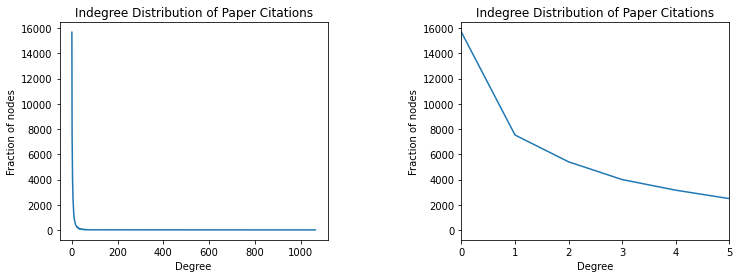

In [27]:
in_degrees = [len(d) for d in papers_citing.values()]
in_values = sorted(set(in_degrees))
in_hist = [in_degrees.count(x) for x in in_values]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=.5) # Add horizontal spacing between subplots
axes[0].plot(in_values, in_hist) # Left plot
axes[0].set_title('Indegree Distribution of Paper Citations')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Fraction of nodes')

axes[1].plot(in_values, in_hist) # Right plot (zoomed in)
axes[1].set_title('Indegree Distribution of Paper Citations')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Fraction of nodes')
axes[1].set_xlim([0,5]);

total = len(papers_citing)
not_cited_rel = 100. * in_hist[0] / total
cited_once_rel = 100. * in_hist[1] / total
cited_twice_rel = 100. * in_hist[2] / total

print('{:.2f} % of papers have been cited zero times by other papers.'.format(not_cited_rel))
print('{:.2f} % of papers have been cited one time by other papers.'.format(cited_once_rel))
print('{:.2f} % of papers have been cited two times by other papers.'.format(cited_twice_rel))

**Answer:** The vast majority of papers are not cited by other papers or are cited only a few times. As the number of citations increases the number of papers that meet this requirement drastically lowers. Nearly one-third of all papers are not cited at all by other papers. ~14% of all papers are cited once, and ~10% are cited twice. The distribution of paper citations seems to follow a power law. Due to the nature of power law, the curve quickly approaches 0% and has a lengthy tail.

Due to the apparent existence of power-law this network might have the scale-free property. We know that new nodes tend to join an existing 'system', in our case the paper not being cited. However, we don't know whether the network has 'preferential attachment' where new papers have a preference to connect with papers that are already being cited by several other papers. Further analysis is necessary to confidently call this network scale-free.

### Task 2

Using the [Link Analysis](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.link_analysis.html) algorithms provided by NetworkX, calculate the PageRank score for all nodes in the citation network, and store the result in a variable called `pageranks`. You can also use the `pagerank_scipy` implementation, which tends to be considerably faster than its regular `pagerank` counterpart, for which you have to install the [SciPy package](http://scipy.org/):

In [28]:
! pip install --user scipy

To test this, create first a list of all papers that are cited by exactly 10 other papers (using `papers_citing` defined above). Then sort these papers by their PageRank and retrieve the paper IDs with the maximum and minimum PageRank values. Print these minimum and maximum PageRank values together with their paper IDs.

To print PageRank values, you might want to use commands like `print('{:.6f}'.format(var))` to use regular decimal notation with a fixed number of decimal places.

In [29]:
pageranks = nx.pagerank_scipy(G)

cited_10_times_rank = {paper : pageranks[paper] for paper, cited_papers in papers_citing.items() if len(cited_papers) == 10}

highest_pagerank = max(cited_10_times_rank.values())
highest_pagerank_papers = [k for k, v in cited_10_times_rank.items() if v == highest_pagerank]

lowest_pagerank = min(cited_10_times_rank.values())
lowest_pagerank_papers = [k for k, v in cited_10_times_rank.items() if v == lowest_pagerank]

print('For papers that have been cited exactly 10 times:')
print('{} are the papers with the highest pagerank of: {:.6f}'.format(*highest_pagerank_papers, highest_pagerank))
print('{} are the papers with the lowest pagerank of: {:.6f}'.format(*lowest_pagerank_papers, lowest_pagerank))

For papers that have been cited exactly 10 times:
1936991 are the papers with the highest pagerank of: 0.000119
26718720 are the papers with the lowest pagerank of: 0.000004


### Task 3

Why do the two papers above have such different PageRank values? Write code below to investigate and show the cause of this, and then explain the cause of this difference based on the results generated by your code.

In [30]:
highest_pagerank_avg = sum([ pageranks[node] for node, edges in G.in_edges(1936991) ]) / len(G.in_edges(1936991))
lowest_pagerank_avg = sum([ pageranks[node] for node, edges in G.in_edges(26718720) ]) / len(G.in_edges(26718720))
print('{:.6f}'.format(highest_pagerank_avg-lowest_pagerank_avg))

0.000026


**Answer:** The difference in pagerank results in our example comes from the contrast in values of pageranks of the nodes that have edges pointing towards a certain node in our directed graph. Based on my calculations, the paper with the highest pagerank has, on average, papers with higher pagerank that are pointing towards it as compared to the paper wit the lowest pagerank which has, on average, papers with lower pagerank pointing towards it.

### Task 4

Copy the scoring function `score_ntn_nnn` from Task 4 of assignment 3. Rename it to `score_ntn_nnn_pagerank` and change its code to incorporate a paper's PageRank score in it's final score, in addition to tf-idf. In other words, the new function should accept a `list` of query tokens and a document ID, and should return a single `float` value that is calculated based on both scores (PageRank and tf-idf). Note that a `tf-idf` function is already provided above. Explain your decision on how to combine the two scores.

In [31]:
import math
def score_ntn_nnn_pagerank(query_words, doc_id):
    tf_score = 0.00
    pagerank_score = pageranks[doc_id]
    
    for word in query_words:
        tf_score += tfidf(word, doc_id)
    
    
    return math.sqrt(tf_score * pagerank_score)

**Answer:** The use of geometric mean is appropriate in this situation given that we may be averaging across numbers on completely different scales. Using arithmetic mean, one of the variables could potentially be overshadowed by the other if the magnitudes of their absolute values differ a lot. Geometric mean attempts to mitigate this issue by normalizing our values onto the same scale.

### Task 5

Copy the query function `query_ntn_nnn` from Task 4 of assignment 3 (also copy `or_merge`). Rename it to `query_ntn_nnn_pagerank` and change the code to use our new scoring function `score_ntn_nnn_pagerank` from task 4 above. Demonstrate these functions with an example query that returns paper 19741609 as the top result.

In [32]:
# Helper functions
def merge_posting_lists(origin_list, output_list, merging_func, index=1):
    # Base case
    if index == len(origin_list):
        return output_list
    # Recursive case
    else:
        return merge_posting_lists(origin_list, merging_func(output_list, origin_list[index]), merging_func, index + 1)

def query_format_check(query):
    assert isinstance(query, str), 'Query has to be a string'

def query_to_postings_id_and_terms(query, smart=False):
    query_format_check(query)
    terms = smarter_tokenize_and_preprocess(query) if smart else preprocess(tokenize(query))
    postings_id = [smarter_index[term] for term in terms] if smart else [inverted_index[term] for term in terms]
    return postings_id, terms

def or_merge(sorted_list1, sorted_list2):
    merged_list = []
    # first we make copies of the lists, so we don't modify the existing lists in the index:
    list1 = list(sorted_list1)
    list2 = list(sorted_list2)
    i, j = 0, 0
    
    while i < len(list1) and j < len(list2):
        # Skip duplicates
        if list1[i] == list2[j]:
            i += 1
            continue
            
        if list1[i] < list2[j]:
            merged_list.append(list1[i])
            i += 1
        else:
            merged_list.append(list2[j])
            j += 1
    
    # Append the list that has not reached the end in the while loop
    merged_list.extend(list1[i:]) if j == len(list2) else merged_list.extend(list2[j:])
    return merged_list

def query_ntn_nnn_pagerank(query_string):
    doc_id_score_dict  = defaultdict(float)
    postings_id, terms = query_to_postings_id_and_terms(query_string)
    matching_docs_id = merge_posting_lists(postings_id, postings_id[0], merging_func=or_merge)
    
    for doc_id in matching_docs_id:
        doc_id_score_dict[doc_id] = score_ntn_nnn_pagerank(terms, doc_id)
    
    doc_id_score_list = sorted(doc_id_score_dict.items(), key=lambda item: item[1], reverse=True)
    return doc_id_score_list[:10]

# Example query that returns 19741609 as the top result
for doc_id, doc_score in query_ntn_nnn_pagerank("Genome sequence and analysis of the Irish potato famine pathogen Phytophthora infestans"):
    score_text = 'Matching score: ' + str(doc_score)
    display_summary(doc_id, extra_text=score_text)

# Submission

Submit the answers to the assignment via Canvas as a modified version of this Notebook file (file with `.ipynb` extension) that includes your code and your answers.

Before submitting, restart the kernel and re-run the complete code (**Kernel > Restart & Run All**), and then check whether your assignment code still works as expected.

Don't forget to add your name, and remember that the assignments have to be done **individually**, and that code sharing or copying are **strictly forbidden** and will be punished.